# Dogs vs. Cats Redux: Kernels Edition

This shows plots in the web page itself - we always wants to use this when using jupyter notebook:

In [1]:
%matplotlib inline

Define path to data: (It's a good idea to put it in a subdirectory of your notebooks folder, and then exclude that directory from git control by adding it to .gitignore.)

In [2]:
path = "data/"
#path = "data/sample/"

A few basic libraries that we'll need for the initial exercises:

In [3]:
from __future__ import division,print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

We have created a file most imaginatively called 'utils.py' to store any little convenience functions we'll want to use. We will discuss these as we use them.

In [4]:
import utils; reload(utils)
from utils import plots

ERROR (theano.sandbox.cuda): nvcc compiler not found on $PATH. Check your nvcc installation and try again.
Using Theano backend.


# Use a pretrained VGG model with our **Vgg16** class

Our first step is simply to use a model that has been fully created for us, which can recognise a wide variety (1,000 categories) of images. We will use 'VGG', which won the 2014 Imagenet competition, and is a very simple model to create and understand. The VGG Imagenet team created both a larger, slower, slightly more accurate model (*VGG  19*) and a smaller, faster model (*VGG 16*). We will be using VGG 16 since the much slower performance of VGG19 is generally not worth the very minor improvement in accuracy.

We have created a python class, *Vgg16*, which makes using the VGG 16 model very straightforward. 

## Use Vgg16 for basic image recognition

Let's start off by using the *Vgg16* class to recognise the main imagenet category for each image.

We won't be able to enter the Cats vs Dogs competition with an Imagenet model alone, since 'cat' and 'dog' are not categories in Imagenet - instead each individual breed is a separate category. However, we can use it to see how well it can recognise the images, which is a good first step.

First, create a Vgg16 object:

In [5]:
# Import our class, and instantiate
import vgg16; reload(vgg16)
from vgg16 import Vgg16
vgg = Vgg16()

Vgg16 is built on top of *Keras* (which we will be learning much more about shortly!), a flexible, easy to use deep learning library that sits on top of Theano or Tensorflow. Keras reads groups of images and labels in *batches*, using a fixed directory structure, where images from each category for training must be placed in a separate folder.

Let's grab batches of data from our training folder:

In [6]:
batches = vgg.get_batches(path+'train', batch_size=4)

Found 23000 images belonging to 2 classes.


(BTW, when Keras refers to 'classes', it doesn't mean python classes - but rather it refers to the categories of the labels, such as 'pug', or 'tabby'.)

*Batches* is just a regular python iterator. Each iteration returns both the images themselves, as well as the labels.

In [7]:
imgs,labels = next(batches)

As you can see, the labels for each image are an array, containing a 1 in the first position if it's a cat, and in the second position if it's a dog. This approach to encoding categorical variables, where an array containing just a single 1 in the position corresponding to the category, is very common in deep learning. It is called *one hot encoding*. 

The arrays contain two elements, because we have two categories (cat, and dog). If we had three categories (e.g. cats, dogs, and kangaroos), then the arrays would each contain two 0's, and one 1.

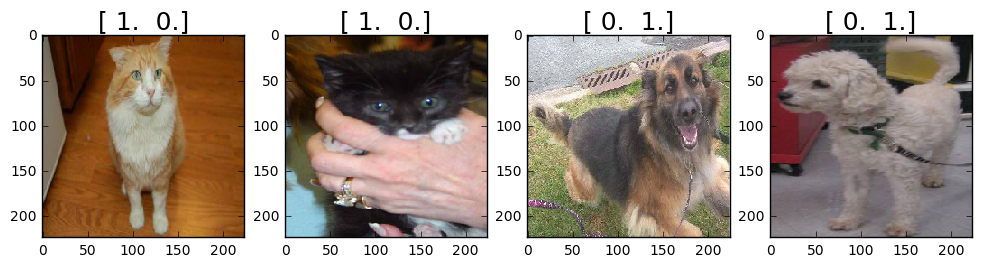

In [8]:
plots(imgs, titles=labels)

We can now pass the images to Vgg16's predict() function to get back probabilities, category indexes, and category names for each image's VGG prediction.

In [246]:
vgg.predict(imgs, True)

(array([ 0.9496,  0.9989,  0.9594,  0.4245], dtype=float32),
 array([284, 283, 235, 284]),
 [u'Siamese_cat', u'Persian_cat', u'German_shepherd', u'Siamese_cat'])

The category indexes are based on the ordering of categories used in the VGG model - e.g here are the first four:

In [72]:
vgg.classes[:4]

[u'tench', u'goldfish', u'great_white_shark', u'tiger_shark']

(Note that, other than creating the Vgg16 object, none of these steps are necessary to build a model; they are just showing how to use the class to view imagenet predictions.)

## Use our Vgg16 class to finetune a Dogs vs Cats model

To change our model so that it outputs "cat" vs "dog", instead of one of 1,000 very specific categories, we need to use a process called "finetuning". Finetuning looks from the outside to be identical to normal machine learning training - we provide a training set with data and labels to learn from, and a validation set to test against. The model learns a set of parameters based on the data provided.

However, the difference is that we start with a model that is already trained to solve a similar problem. The idea is that many of the parameters should be very similar, or the same, between the existing model, and the model we wish to create. Therefore, we only select a subset of parameters to train, and leave the rest untouched. This happens automatically when we call *fit()* after calling *finetune()*.

We create our batches just like before, and making the validation set available as well. A 'batch' (or *mini-batch* as it is commonly known) is simply a subset of the training data - we use a subset at a time when training or predicting, in order to speed up training, and to avoid running out of memory.

In [7]:
batch_size=32

In [8]:
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


Calling *finetune()* modifies the model such that it will be trained based on the data in the batches provided - in this case, to predict either 'dog' or 'cat'.

In [9]:
vgg.finetune(batches)

Finally, we *fit()* the parameters of the model using the training data, reporting the accuracy on the validation set after every epoch. (An *epoch* is one full pass through the training data.)

In [ ]:
vgg.fit(batches, val_batches, nb_epoch=1)

Epoch 1/1
  160/23000 [..............................] - ETA: 9416s - loss: 1.5876 - acc: 0.6750

Lets test the re-trained Dogs & Cats model.

In [13]:
test_path = "data/test"

In [ ]:
test_batches, test_preds = vgg.test(test_path, batch_size = batch_size*2)

Found 12500 images belonging to 1 classes.


In [ ]:
# grab filenames
test_filenames = test_batches.filenames

In [ ]:
# grab prediction for probability to be a Dog
test_predictions = test_preds[:,1]

In [ ]:
from keras.preprocessing import image

#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots_idx(idx, path, filenames, probabilities):
    my_image_ids = np.array([int(filenames[i][8:filenames[i].find('.')]) for i in idx])
    my_probabilities = [probabilities[i] for i in idx]
    my_labels = ["{}={:0.5f}".format(i, j) for i,j in zip(my_image_ids, my_probabilities)]
    plots([image.load_img(path + filenames[i]) for i in idx], titles=my_labels)
    


In [ ]:
#Number of images to view for each visualization task
n_view = 4

#print out prediction of a few test images
idx = np.random.permutation(range(0,len(test_filenames)))[:n_view]
plots_idx(idx, path+'test/', test_filenames, test_predictions)

In [ ]:
# prepare data for Kaggle submission

test_image_ids = np.array([int(f[8:f.find('.')]) for f in test_filenames])
#So to play it safe, we use a sneaky trick to round down our edge predictions
#Swap all ones with .95 and all zeros with .05
test_predictions = test_predictions.clip(min=0.05, max=0.95)
subm = zip(test_image_ids, test_predictions)


In [ ]:
# write Kaggle submission file
submission_file_name = 'submission1.csv'
np.savetxt(submission_file_name, subm, fmt='%d,%.5f', header='id,label', comments='')

# Create a VGG model from scratch in Keras

For the rest of this tutorial, we will not be using the Vgg16 class at all. Instead, we will recreate from scratch the functionality we just used. This is not necessary if all you want to do is use the existing model - but if you want to create your own models, you'll need to understand these details. It will also help you in the future when you debug any problems with your models, since you'll understand what's going on behind the scenes.

## Model setup

We need to import all the modules we'll be using from numpy, scipy, and keras:

In [26]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

Let's import the mappings from VGG ids to imagenet category ids and descriptions, for display purposes later.

In [27]:
FILES_PATH = 'http://www.platform.ai/models/'; CLASS_FILE='imagenet_class_index.json'
# Keras' get_file() is a handy function that downloads files, and caches them for re-use later
fpath = get_file(CLASS_FILE, FILES_PATH+CLASS_FILE, cache_subdir='models')
with open(fpath) as f: class_dict = json.load(f)
# Convert dictionary with string indexes into an array
classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

Here's a few examples of the categories we just imported:

In [28]:
classes[:5]

[u'tench', u'goldfish', u'great_white_shark', u'tiger_shark', u'hammerhead']

## Model creation

Creating the model involves creating the model architecture, and then loading the model weights into that architecture. We will start by defining the basic pieces of the VGG architecture.

VGG has just one type of convolutional block, and one type of fully connected ('dense') block. Here's the convolutional block definition:

In [29]:
def ConvBlock(layers, model, filters):
    for i in range(layers): 
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

...and here's the fully-connected definition.

In [30]:
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

When the VGG model was trained in 2014, the creators subtracted the average of each of the three (R,G,B) channels first, so that the data for each channel had a mean of zero. Furthermore, their software that expected the channels to be in B,G,R order, whereas Python by default uses R,G,B. We need to preprocess our data to make these two changes, so that it is compatible with the VGG model:

In [31]:
# Mean of each channel as provided by VGG researchers
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))

def vgg_preprocess(x):
    x = x - vgg_mean     # subtract mean
    return x[:, ::-1]    # reverse axis bgr->rgb

Now we're ready to define the VGG model architecture - look at how simple it is, now that we have the basic blocks defined!

In [32]:
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,224,224)))

    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1000, activation='softmax'))
    return model

We'll learn about what these different blocks do later in the course. For now, it's enough to know that:

- Convolution layers are for finding patterns in images
- Dense (fully connected) layers are for combining patterns across an image

Now that we've defined the architecture, we can create the model like any python object:

In [33]:
model = VGG_16()

As well as the architecture, we need the weights that the VGG creators trained. The weights are the part of the model that is learnt from the data, whereas the architecture is pre-defined based on the nature of the problem. 

Downloading pre-trained weights is much preferred to training the model ourselves, since otherwise we would have to download the entire Imagenet archive, and train the model for many days! It's very helpful when researchers release their weights, as they did here.

In [34]:
fpath = get_file('vgg16.h5', FILES_PATH+'vgg16.h5', cache_subdir='models')
model.load_weights(fpath)

553418752/553482496 [============================>.] - ETA: 0s

## Getting imagenet predictions

The setup of the imagenet model is now complete, so all we have to do is grab a batch of images and call *predict()* on them.

In [35]:
batch_size = 4

Keras provides functionality to create batches of data from directories containing images; all we have to do is to define the size to resize the images to, what type of labels to create, whether to randomly shuffle the images, and how many images to include in each batch. We use this little wrapper to define some helpful defaults appropriate for imagenet data:

In [36]:
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, 
                batch_size=batch_size, class_mode='categorical'):
    return gen.flow_from_directory(path+dirname, target_size=(224,224), 
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

From here we can use exactly the same steps as before to look at predictions from the model.

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


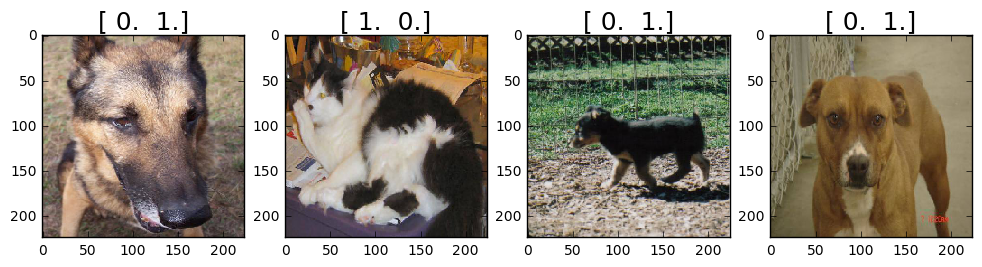

In [42]:
batches = get_batches('train', batch_size=batch_size)
val_batches = get_batches('valid', batch_size=batch_size)
imgs,labels = next(batches)

# This shows the 'ground truth'
plots(imgs, titles=labels)

The VGG model returns 1,000 probabilities for each image, representing the probability that the model assigns to each possible imagenet category for each image. By finding the index with the largest probability (with *np.argmax()*) we can find the predicted label.

In [38]:
def pred_batch(imgs):
    preds = model.predict(imgs)
    idxs = np.argmax(preds, axis=1)

    print('Shape: {}'.format(preds.shape))
    print('First 5 classes: {}'.format(classes[:5]))
    print('First 5 probabilities: {}\n'.format(preds[0, :5]))
    print('Predictions prob/class: ')
    
    for i in range(len(idxs)):
        idx = idxs[i]
        print ('  {:.4f}/{}'.format(preds[i, idx], classes[idx]))

In [43]:
pred_batch(imgs)

Shape: (4, 1000)
First 5 classes: [u'tench', u'goldfish', u'great_white_shark', u'tiger_shark', u'hammerhead']
First 5 probabilities: [  1.2762e-08   2.3712e-10   3.3695e-09   2.4646e-09   9.4356e-10]

Predictions prob/class: 
  0.6345/German_shepherd
  0.2317/Shetland_sheepdog
  0.1761/Australian_terrier
  0.4375/American_Staffordshire_terrier
